# Pricing with Rational Inattention: Partial Equilibrium with No Feedback


This notebook goes through a couple of examples for solving LQG Dynamic Rational Inattention pricing models in partial equilibrium using the methods and the [solver](https://github.com/choongryulyang/dynamic_multivariate_RI) from [Afrouzi and Yang (2019)](http://www.afrouzi.com/dynamic_inattention.pdf) that was adapted for Julia by [Miguel Acosta](https://www.acostamiguel.com/home). To include the solver, execute:

In [1]:
include("Solve_RI_Dynamics.jl");

## Example 1a: The Case with Only Aggregate Shocks
There is a measure of firms indexed by $i\in[0,1]$. Firm $i$ chooses its price $p_{i,t}$ at time $t$ to track its ideal price $p_{i,t}^*$. Formally, her flow profit is  
    $$-(p_{i,t}-p_{i,t}^*)^2$$
    
We start by assuming that $p_{i,t}^*=q_t$ where
\begin{align}
    \Delta q_t&=\rho \Delta q_{t-1}+u_t,\quad u_t\sim \mathcal{N}(0,\sigma_u^2) 
\end{align}
Here $q_t$ can be interpreted as money growth or the nominal aggregate demand. Therefore, the state-space representation of the problem is 
\begin{align}
   \vec{x}_{t}&=\left[\begin{array}{c}
    q_{t}\\
    \Delta q_{t}
    \end{array}\right] 
    = \underset{\mathbf{A}}{\underbrace{\left[\begin{array}{cc}
    1 & \rho \\
    0 & \rho \\
    \end{array}\right]}}\, \vec{x}_{t-1} 
    + \underset{\mathbf{Q}}{\underbrace{\left[\begin{array}{c}
    \sigma_u  \\
    \sigma_u \\
    \end{array}\right]}}\, u_t, \\
    p_{i,t}^*&=\underset{\mathbf{H}}{\underbrace{\left[\begin{array}{c}
    1 \\
    0 \\
    \end{array}\right]}}'\vec{x}_t
\end{align}

Assign value to deep parameters and define the structure of the problem

In [2]:
ρ   = 0.6;        #persistence of money growth
σ_u = 1;          #std. deviation of shocks to money growth

## specifying the primitives of the drip
ω   = 100;       
β   = 0.96^0.25;  
A   = [1 ρ; 0 ρ]; 
Q   = σ_u*[1; 1];
H   = [1; 0];

#### Solve

In [3]:
@time ex1  = Solve_RI_Dynamics(ω,β,A,Q,H);

 14.782671 seconds (56.65 M allocations: 2.651 GiB, 7.30% gc time)


Get IRFs:

In [4]:
ex1irfs = dripirfs(ex1,20);

Let's plot how the average price $p=\int_0^1 p_{i,t}di$ responds to a shock to money growth:

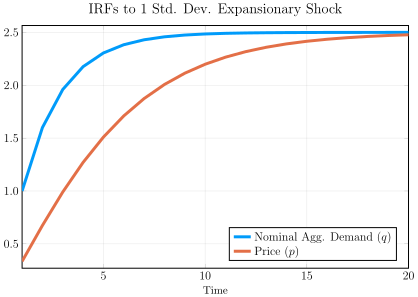

In [5]:
using Plots, LaTeXStrings; pgfplots()
plot(1:ex1irfs.T,[ex1irfs.x[1,1,:],ex1irfs.a[1,1,:]],
    xlabel     = "Time",
    label      = [L"Nominal Agg. Demand ($q$)" L"Price ($p$)"],
    title      = "IRFs to 1 Std. Dev. Expansionary Shock",
    xlim       = (1,ex1irfs.T),
    lw         = 3,
    legend     = :bottomright,
    legendfont = font(12),
    tickfont   = font(12),
    framestyle = :box)

We can also plot the IRFs of inflation $\pi_t\equiv p_t-p_{t-1}$ and output $y_t\equiv q_t-p_t$ to 1 percent expansionary shock to $q$:

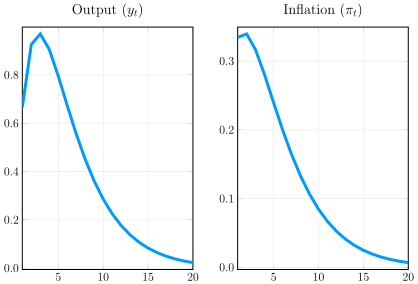

In [6]:
p1 = plot(1:ex1irfs.T,ex1irfs.x[1,1,:]-ex1irfs.a[1,1,:],
    title  = L"Output ($y_t$)")

p2 = plot(1:ex1irfs.T,[ex1irfs.a[1,1,1];ex1irfs.a[1,1,2:end]-ex1irfs.a[1,1,1:end-1]],
    title  = L"Inflation ($\pi_t$)")

display(plot(p1,p2,
    layout     = (1,2),
    xlim       = (1,ex1irfs.T),
    lw         = 3,
    legend     = false,
    tickfont   = font(12),
    framestyle = :box));

## Example 1b: The Case with Transitory Shocks
Suppose now that $p_{i,t}^*=q_t-z_{t}$ where
\begin{align}
    \Delta q_t&=\rho \Delta q_{t-1}+u_t,\quad u_t\sim \mathcal{N}(0,\sigma_u^2) \\
    z_{t}&\sim \mathcal{N}(0,\sigma_z^2) 
\end{align}
Here $q_t$ can be interpreted as money growth and $z_{i,t}$ as an idiosyncratic TFP shock. Therefore, 
\begin{align}
   \vec{x}_{t}&=\left[\begin{array}{c}
    q_{t}\\
    \Delta q_{t} \\
    z_{t}
    \end{array}\right] 
    = \underset{\mathbf{A}}{\underbrace{\left[\begin{array}{ccc}
    1 & \rho & 0\\
    0 & \rho & 0\\
    0 & 0 & 0 \\
    \end{array}\right]}}\, \vec{x}_{t-1} 
    + \underset{\mathbf{Q}}{\underbrace{\left[\begin{array}{cc}
    \sigma_u & 0 \\
    \sigma_u & 0 \\
    0 & \sigma_z   \\
    \end{array}\right]}}\, \left[\begin{array}{c}
    u_t  \\
    z_{t}   \\
    \end{array}\right], \\
    p_{i,t}^*&=\underset{\mathbf{H}}{\underbrace{\left[\begin{array}{c}
    1     \\
    0 \\
    -1 \\
    \end{array}\right]}}'\vec{x}_{t}
\end{align}

Assign values:

In [118]:
ρ   = 0.6;        #persistence of money growth
σ_u = 1;          #std. deviation of shocks to money growth
σ_z = √10;      #std. deviation of idiosyncratic shock

## specifying the primitives of the drip
ω   = 100;       
β   = 0.96^0.25;  
A   = [1 ρ 0; 0 ρ 0; 0 0 0]; 
Q   = [σ_u 0; σ_u 0; 0 σ_z];
H   = [1; 0; -1];

#### Solve

In [119]:
@time ex2  = Solve_RI_Dynamics(ω,β,A,Q,H);

  0.215363 seconds (431.44 k allocations: 58.125 MiB, 27.51% gc time)


Get the IRFs:

In [120]:
ex2irfs = dripirfs(ex2,20);

To get the IRFs simply use the law of motion for actions:

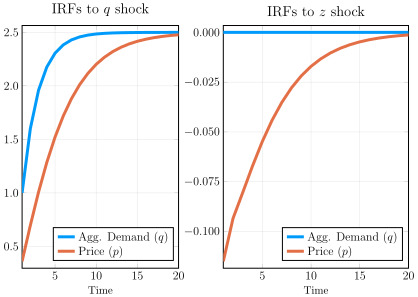

In [121]:
p1 = plot(1:ex2irfs.T,[ex2irfs.x[1,1,:],ex2irfs.a[1,1,:]],
    title  = L"IRFs to $q$ shock");
p2 = plot(1:ex1irfs.T,[ex2irfs.x[1,2,:],ex2irfs.a[1,2,:]],
    title  = L"IRFs to $z$ shock");

plot(p1,p2, layout = (1,2),
    xlabel     = "Time",
    label      = [L"Agg. Demand ($q$)" L"Price ($p$)"],
    xlim       = (1,ex2irfs.T),
    lw         = 3,
    legend     = :bottomright,
    legendfont = font(12),
    tickfont   = font(12),
    framestyle = :box)

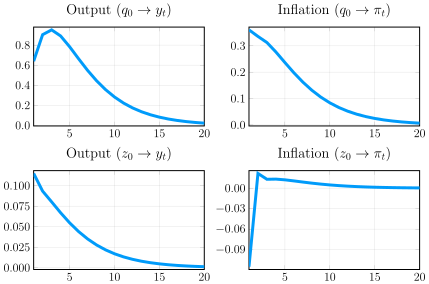

In [122]:
p1 = plot(1:ex2irfs.T,ex2irfs.x[1,1,:]-ex2irfs.a[1,1,:],
    title  = L"Output ($q_0\to y_t$)");

p2 = plot(1:ex2irfs.T,[ex2irfs.a[1,1,1];ex2irfs.a[1,1,2:end]-ex2irfs.a[1,1,1:end-1]],
    title  = L"Inflation ($q_0\to \pi_t$)")

p3 = plot(1:ex2irfs.T,ex2irfs.x[1,2,:]-ex2irfs.a[1,2,:],
    title  = L"Output ($z_0\to y_t$)");

p4 = plot(1:ex2irfs.T,[ex2irfs.a[1,2,1];ex2irfs.a[1,2,2:end]-ex2irfs.a[1,2,1:end-1]],
    title  = L"Inflation ($z_0\to \pi_t$)")

plot(p1,p2,p3,p4, layout = (2,2),
    xlim       = (1,ex2irfs.T),
    lw         = 3,
    legend     = false,
    tickfont   = font(12),
    framestyle = :box)
